# Advanced Lane Lines Detection

The goals / steps of this project are the following:

* Apply a perspective transform to rectify image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [ ]:
from LaneDetector import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
image_paths = glob.glob('assets/test_images/*.jpg')

##### The function prepare handles image preprocessing 
###### Preprocessing the image involves : 
- Perspective transformation : In Perspective Transformation, we need to provide the points on the image from which want togather information by changing the perspective which in this case were chosen to be (696,455),(587,455),(235,700),(1075,700). We also need to provide the points inside which we want to display our image these are (width - 350, 0),(350, 0),(350, height),(width - 350, height) . Then, we get the perspective transform from the two given sets of points and wrap it with the original image.
    
- ROI crop : In other words selecting the Region of Interest which is the part of the image in which we are interested (in this case the part that holds the lane) . 

In [ ]:
# below are the 4 points: we can see they provide a good trapezoid for perspective  
image_test1 = mpimg.imread(image_paths[0])
cv2.circle(image_test1,(696,455),10,(0,0,255),-1) #Top right
cv2.circle(image_test1,(587,455),10,(0,0,255),-1) #Top left
cv2.circle(image_test1,(235,700),10,(0,0,255),-1) #Bottom left 
cv2.circle(image_test1,(1075,700),10,(0,0,255),-1) #Bottom right
plt.imshow(image_test1)

In [ ]:
def prepare(img_path, visualise=False):
    '''
    Load an image from the 'img_path' and pre-process it
    :param img_path (string): Image path
    :param visualise (boolean): Boolean flag for visualisation
    :return : Transformed Image, (PT matrix, PT inv matrix)
    '''
    img = mpimg.imread(img_path)
    return preprocess_image(img, visualise=visualise)

## 1. Perspective Transformation

In [ ]:
for path in image_paths[:]:
        prepare(path, visualise=True)

## 2. Generate Thresholded Binary image

- Lane line are either white or yellow.

- Lane lines could be discontinuous thats why the algorithm should be able to identify lines even if they are not connected.

- Thresholding is a type of image segmentation, where we change the pixels of an image to make the image easier to analyze.

- In thresholding, we convert an image from color or grayscale into a binary image.

- In this code we experimented with several color spaces as well as adaptive thresholding using a Gaussian kernel (to handle the uneven road surfaces and the non-uniform lighting conditions) . All these color spaces LAB (Yellow), HSV (Yellow + White), HLS (Yellow + White), RGB (White) provide many color channels. 

- White submask was created through a Logical AND of RGB R-channel and HSV V-channel.

- Yellow submask was created through a Logical AND of LAB B-channel and HLS S-channel.

- Mask = Sub-mask (white) | Sub-mask (yellow)

- Each channel is binary thresholded.

- Binary images from all channels are combined.

- Ensemble Voting applied. That is we vote upon the channels wether the pixel in the combined image is a black pixel or a white pixel. The result is an output binary image combining a number of channels(in binary) that shows enough information to properly detect lanes. The use of this technique improves pixel detection significantly.

In [ ]:
img, _ = prepare(image_paths[0])
_ = get_binary_image(img, visualise=True)

## 3. Detect Lane Lines: Peaks in Histogram & Sliding Window Technique

- This stage Computes the histogram along all the columns in the lower half of the image. 
- The two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines
- Using these points as start points we apply sliding windows to follow the line along the image
    

In [ ]:
for path in image_paths[:]:
        find_lane = LaneDetector()
        img, _ = prepare(path)
        binary = get_binary_image(img, visualise=False)
        find_lane.polyfit_sliding_window(binary, visualise=True)

## 4. Detect Lane Lines: Adaptive Search 

- For subsequent frames in a video, we search in a margin around the previous line
- The histogram technique often fails when subject to non-uniform lighting conditions and discolouration. So, a method that could perform adaptive thresholding over a smaller receptive field/window of the image was applied.
- This method follows along the trajectory of the previous polyfit lines and splits the image into a number of smaller windows.
- These windows are then iteratively passed into the get_binary_image function and their threshold values are computed as the mean of the pixel intensity values across the window
- Following this iterative thresholding process, the returned binary windows are stacked together to get a single large binary image with dimensions same as that of the input image

In [ ]:
capture = cv2.VideoCapture('assets/project_video.mp4')

videoframes = []

while True:
    success, frame = capture.read()
    if not success:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    videoframes.append(frame)
    

In [ ]:
for img in videoframes[0: 3]:
    
    warped, (M, invM) = preprocess_image(img)
    find_lane = LaneDetector()
    
    max_attempts = 5
    
    if find_lane.reset == True:
        binary = get_binary_image(warped)
        ret, out, poly_param = find_lane.polyfit_sliding_window(binary, visualise=False, diagnostics=True)
        if ret:
            find_lane.reset = False
            find_lane.cache = np.array([poly_param])

    else:
        out, poly_param = find_lane.polyfit_adapt_search(warped, poly_param, visualise=False, diagnostics=False)
        if find_lane.attempts == max_attempts:
            find_lane.attempts = 0
            laneDetreset = True

    out_unwarped = cv2.warpPerspective(out, invM, (IMG_SHAPE[1], IMG_SHAPE[0]), flags=cv2.INTER_LINEAR)

    img_overlay = np.copy(img)
    img_overlay = cv2.addWeighted(out_unwarped, 0.5, img, 0.5, 0)

    plotting([(warped, 'Original'), (out, 'Out'), (img_overlay, 'Overlay')], figsize=(20, 10))

## 7. Compute meters/pixel

In [ ]:
def visualize_mppx(img,x_left,x_right,y_top,y_bottom,dashed_line_loc,dashed_line_len,lane_width):
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
        
    if dashed_line_loc == 'left':
        plt.plot((x_left, x_left), (y_top, y_bottom), 'r')
        plt.text(x_left + 10, (y_top + y_bottom) // 2, '{} m'.format(dashed_line_len), color='r', fontsize=20)

    elif dashed_line_loc == 'right':
        plt.plot((x_right, x_right), (y_top, y_bottom), 'r')
        plt.text(x_right + 10, (y_top + y_bottom) // 2, '{} m'.format(dashed_line_len), color='r',fontsize=20)

    plt.plot((x_left, x_right), (img.shape[0] - 200 , img.shape[0] - 200), 'r')
    plt.text((x_left + x_right) // 2, img.shape[0] - 220, '{} m'.format(lane_width), color='r', fontsize=20)

In [ ]:
def compute_mppx(img, dashed_line_loc, visualise=False):
    '''
    Converts from pixel space to real world space and calculates the metres/pixel
    :param img (ndarray): Warped Image
    :param dashed_line_loc (string): Dashed line location (left/right)
    :param visualise (boolean): Boolean flag for visualisation
    : return (float32, float32): (metres/pixel y direction, metres/pixel x-direction)
    '''
    lane_width = 3.7
    dashed_line_len = 3.048
    
    if dashed_line_loc == 'left':
        y_top = 295
        y_bottom = 405
    elif dashed_line_loc == 'right':
        y_top = 395
        y_bottom = 495
        
    binary = get_binary_image(img)
    histogram = np.sum(binary[int(binary.shape[0] / 2):, :], axis=0)
    midpoint = int(histogram.shape[0] / 2)
    
    x_left = np.argmax(histogram[:midpoint])
    x_right = np.argmax(histogram[midpoint:]) + midpoint
    
    x_mppx = lane_width / (x_right - x_left)
    y_mppx = dashed_line_len / (y_bottom - y_top)
    
    if visualise:
        check=visualize_mppx(img,x_left,x_right,y_top,y_bottom,dashed_line_loc,dashed_line_len,lane_width)
    return y_mppx, x_mppx

In [ ]:
img, _ = prepare(image_paths[0])
y_mppx1, x_mppx1 = compute_mppx(img, dashed_line_loc='right', visualise=True)

img, _ = prepare(image_paths[1])
y_mppx2, x_mppx2 = compute_mppx(img, dashed_line_loc='left', visualise=True)

x_mppx = (x_mppx1 + x_mppx2) / 2
y_mppx = (y_mppx1 + y_mppx2) / 2

print('Average meter/px along x-axis: {:.4f}'.format(x_mppx))
print('Average meter/px along y-axis: {:.4f}'.format(y_mppx))

## 8. Compute Lane Line Curvature

#### we compute the radius of the curvature using the following eqns

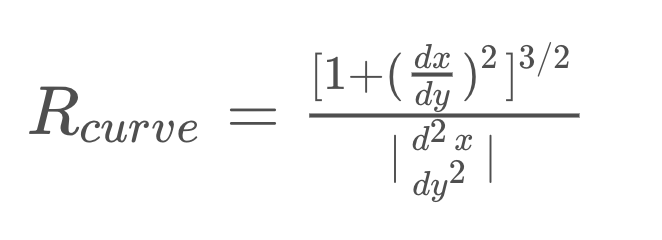

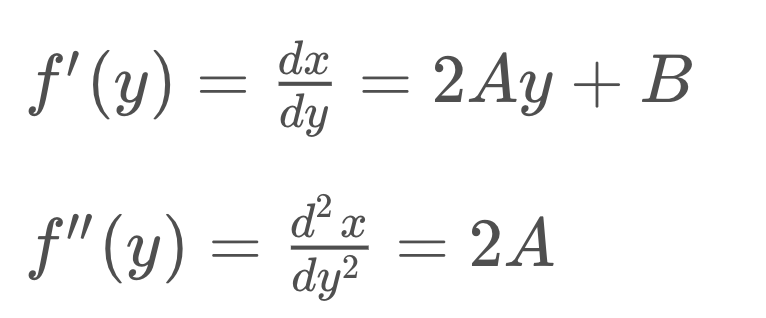

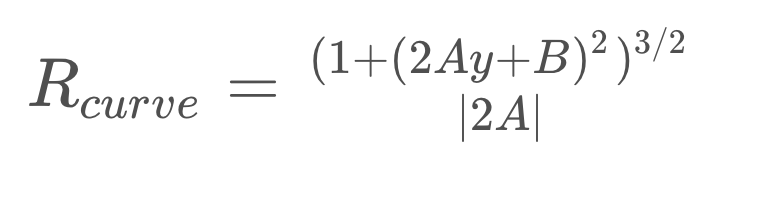

In [ ]:
find_lane = LaneDetector()

for img in videoframes[1000: 1010]:

    warped, (M, invM) = preprocess_image(img)

    binary = get_binary_image(warped)
    ret, img_poly, poly_param = find_lane.polyfit_sliding_window(binary)

    left_curverad, right_curverad = find_lane.compute_curvature(poly_param, y_mppx, x_mppx)
    curvature = (left_curverad + right_curverad) / 2
    offset = find_lane.compute_offset_from_center(poly_param, x_mppx)
    result = find_lane.draw(img, warped, invM, poly_param, curvature, offset)

    plotting([(img_poly, 'Polyfit'), (result, 'Result')])

## 9. Pipeline

The pipeline runs each of the stages above in sequence for each video frame 

In [ ]:
find_lane = LaneDetector()

for img in videoframes[0:15]:
    result = find_lane.pipeline(img, visualise=True, diagnostics=1)

In [ ]:
images1 = glob.glob('test_images/*.jpg')

find_lane = LaneDetector()

img = mpimg.imread(images1[0])

_ = find_lane.pipeline(img, visualise=True, diagnostics=True)

## 9. Process Video

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Project Video

In [ ]:
find_lane = LaneDetector()

process_frame = lambda frame: find_lane.pipeline(frame, Verbose = True, diagnostics=False)

video_output = 'assets/project_video_output.mp4'
video_input = VideoFileClip('assets/project_video.mp4')                          
processed_video = video_input.fl_image(process_frame)
%time processed_video.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(video_output))

### Challenge Video

In [ ]:
find_lane = LaneDetector()

process_frame = lambda frame: find_lane.pipeline(frame, Verbose = True, diagnostics=False)

video_output = 'assets/challenge_video_output.mp4'
video_input = VideoFileClip('assets/challenge_video.mp4')                          
processed_video = video_input.fl_image(process_frame)
%time processed_video.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(video_output))